### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from  sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis.


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [2]:
# SD: Problem 1
# SD: task 1
file = np.load("../../../homeworks/hw_data/hw8_data_1.npy") # SD: load in the file
print("Column Names:", file.dtype.names)

u_g = file["u"] - file["g"]
g_r = file["g"] - file["r"]
r_i = file["r"] - file["i"]
i_z = file["i"] - file["z"]
spec_class = file["specClass"]
redshift = file["redshift"]
redshift_err = file["redshift_err"]

print(collections.Counter(spec_class))

Column Names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Counter({'GALAXY': 42808, 'QSO': 7192})


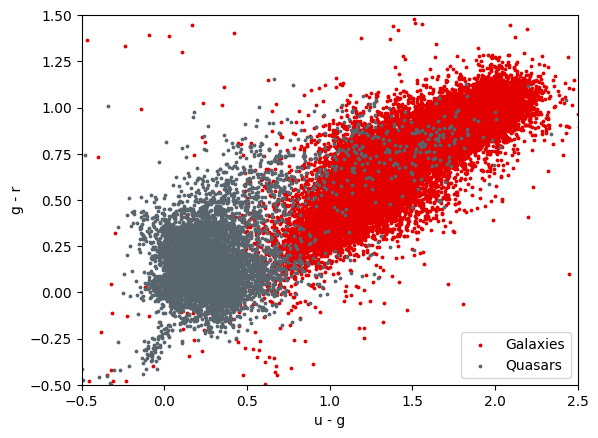

In [3]:
# SD: task 2
galaxy_mask = spec_class == "GALAXY"
quasar_mask = spec_class == "QSO"

plt.scatter(u_g[galaxy_mask], g_r[galaxy_mask], color="xkcd:red", s=3, label="Galaxies")
plt.scatter(u_g[quasar_mask], g_r[quasar_mask], color="xkcd:slate gray", s=3, label="Quasars")
plt.xlabel("u - g")
plt.ylabel("g - r")
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.show()

In [ ]:
# SD: task 3
X = np.stack((g_r, r_i, i_z, u_g, redshift)).T
y = quasar_mask.astype(int) # SD: mask is already True/False for quasars/galaxies - just converting bool representation into int

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

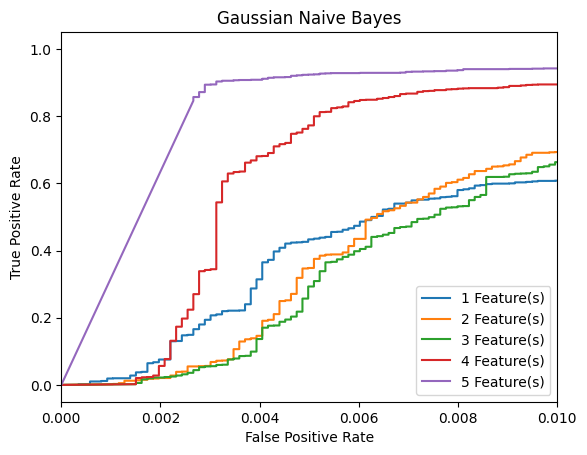

In [ ]:
# SD: task 4
for i in range(1, X.shape[1] + 1):
    clf = GaussianNB()
    clf.fit(X_train[:, :i], y_train)
    # print(clf.classes_) # SD: quasar (== 1) is the second class (so i=1) in the clf classes
    q_prob = clf.predict_proba(X_test[:, :i])[:, 1] # SD: taking only probability of it being a quasar (y is 1 when quasar - we want to match that)
    fpr, tpr, _ = roc_curve(y_test, q_prob)
    plt.plot(fpr, tpr, label=f"{i} Feature(s)")
plt.xlim(0, 0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gaussian Naive Bayes")
plt.legend()
plt.show()
# SD: I switched around the order of features (when making the X stack in task 3) to see how they effect the ROC curve.
# SD: This version shows it clearly: redshift is the feature that makes the classification trivially easy.

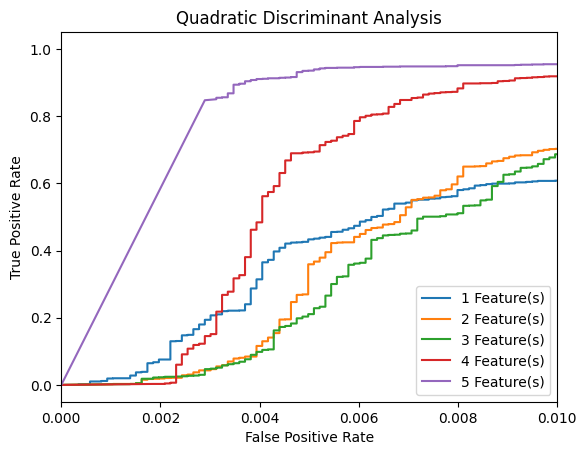

In [ ]:
# SD: task 5
for i in range(1, X.shape[1] + 1):
    clf = QDA() # SD: literally copy paste with this line changed
    clf.fit(X_train[:, :i], y_train)
    q_prob = clf.predict_proba(X_test[:, :i])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, q_prob)
    plt.plot(fpr, tpr, label=f"{i} Feature(s)")
plt.xlim(0, 0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Quadratic Discriminant Analysis")
plt.legend()
plt.show()
# SD: Again, redshift is the feature that makes the classification trivially easy.

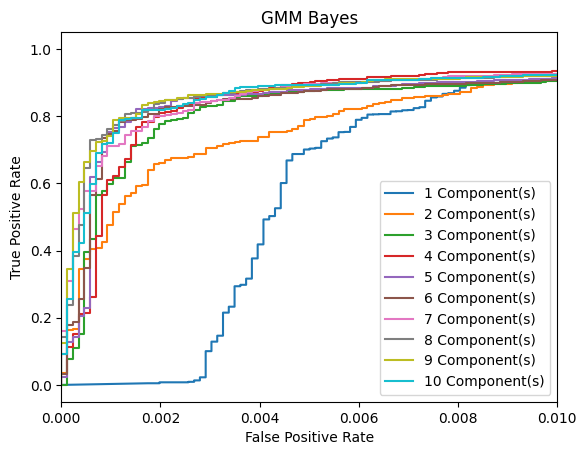

Best performance at 4 component(s)


In [7]:
# SD: task 6
X = np.stack((u_g, g_r, r_i, i_z)).T
y = quasar_mask.astype(int)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

area_under_curve = []
n_components = np.arange(1, 11)
for i in n_components:
    clf = GMMBayes(n_components=i)
    clf.fit(X_train, y_train)
    q_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, q_prob)
    plt.plot(fpr, tpr, label=f"{i} Component(s)")
    area_under_curve.append(roc_auc_score(y_test, q_prob))
plt.xlim(0, 0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GMM Bayes")
plt.legend()
plt.show()
gmm_best = n_components[np.argmax(area_under_curve)]
print(f"Best performance at {gmm_best} component(s)")

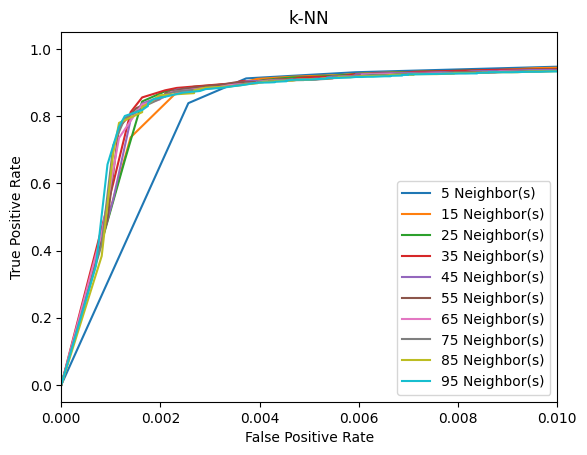

Best performance at 85 neighbor(s)


In [8]:
# SD: task 7
area_under_curve = []
n_neighbors = np.arange(5, 100, 10)
for i in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    q_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, q_prob)
    plt.plot(fpr, tpr, label=f"{i} Neighbor(s)")
    area_under_curve.append(roc_auc_score(y_test, q_prob))
plt.xlim(0, 0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("k-NN")
plt.legend()
plt.show()
knn_best = n_neighbors[np.argmax(area_under_curve)]
print(f"Best performance at {knn_best} neighbor(s)")

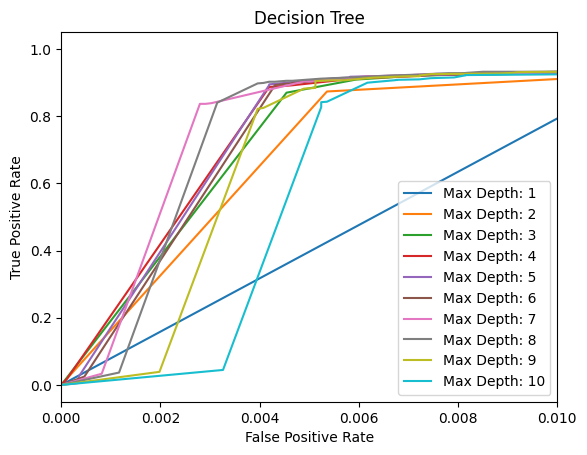

Best performance at max depth of 4


In [9]:
# SD: task 8
area_under_curve = []
max_depth = np.arange(1, 11)
for i in max_depth:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    q_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, q_prob)
    plt.plot(fpr, tpr, label=f"Max Depth: {i}")
    area_under_curve.append(roc_auc_score(y_test, q_prob))
plt.xlim(0, 0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree")
plt.legend()
plt.show()
dtree_best = max_depth[np.argmax(area_under_curve)]
print(f"Best performance at max depth of {dtree_best}")

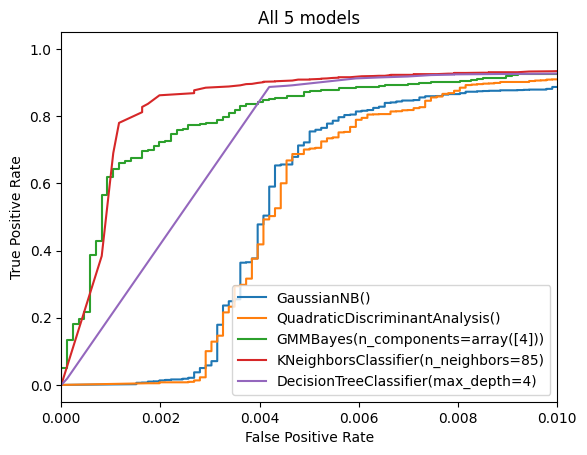

Best performing model: KNeighborsClassifier(n_neighbors=85)


In [10]:
# SD: task 9
models = [GaussianNB(), QDA(), GMMBayes(n_components=gmm_best), KNeighborsClassifier(n_neighbors=knn_best), DecisionTreeClassifier(max_depth=dtree_best)]
area_under_curve = []
for clf in models:
    clf.fit(X_train, y_train)
    q_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, q_prob)
    plt.plot(fpr, tpr, label=f"{clf}")
    area_under_curve.append(roc_auc_score(y_test, q_prob))
plt.xlim(0, 0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("All 5 models")
plt.legend()
plt.show()
best_model = models[np.argmax(area_under_curve)]
print(f"Best performing model: {best_model}")

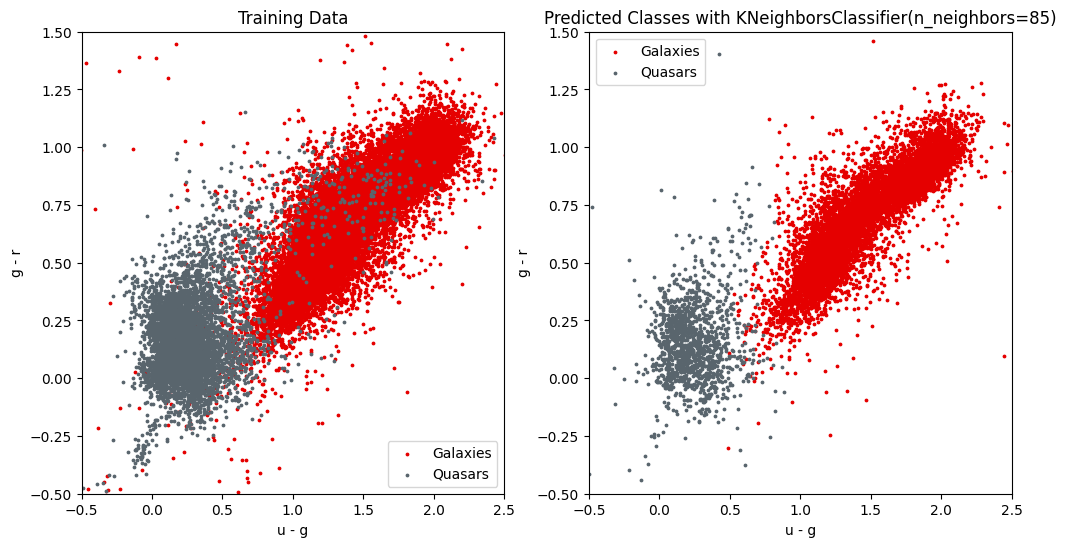

In [11]:
# SD: task 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], color="xkcd:red", s=3, label="Galaxies")
ax1.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], color="xkcd:slate gray", s=3, label="Quasars")
ax1.set_xlabel("u - g")
ax1.set_ylabel("g - r")
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 1.5)
ax1.legend()
ax1.set_title("Training Data")

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

ax2.scatter(X_test[y_pred==0][:, 0], X_test[y_pred==0][:, 1], color="xkcd:red", s=3, label="Galaxies")
ax2.scatter(X_test[y_pred==1][:, 0], X_test[y_pred==1][:, 1], color="xkcd:slate gray", s=3, label="Quasars")
ax2.set_xlabel("u - g")
ax2.set_ylabel("g - r")
ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(-0.5, 1.5)
ax2.legend()
ax2.set_title(f"Predicted Classes with {best_model}")
plt.show()

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

In [ ]:
# SD: Problem 2
# SD: task 1
file = np.load("../../../homeworks/hw_data/hw8_data_1.npy") # SD: load in the file
file = file[::10]

u_g = file["u"] - file["g"]
g_r = file["g"] - file["r"]
r_i = file["r"] - file["i"]
i_z = file["i"] - file["z"]
spec_class = file["specClass"]
redshift = file["redshift"]
redshift_err = file["redshift_err"]

print(collections.Counter(spec_class))

Counter({'GALAXY': 4264, 'QSO': 736})


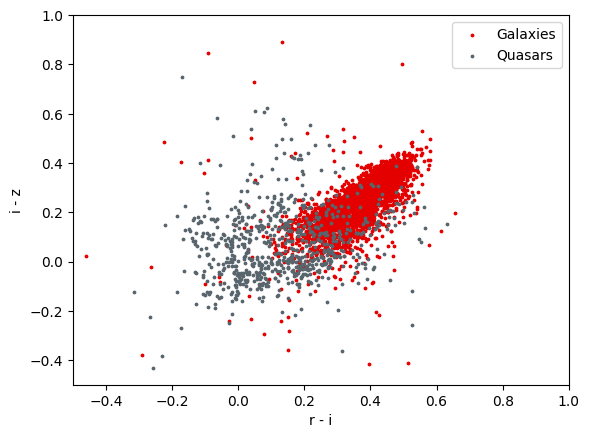

In [17]:
# SD: task 2
galaxy_mask = spec_class == "GALAXY"
quasar_mask = spec_class == "QSO"

plt.scatter(r_i[galaxy_mask], i_z[galaxy_mask], color="xkcd:red", s=3, label="Galaxies")
plt.scatter(r_i[quasar_mask], i_z[quasar_mask], color="xkcd:slate gray", s=3, label="Quasars")
plt.xlabel("r - i")
plt.ylabel("i - z")
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)
plt.legend()
plt.show()

In [18]:
# SD: task 3
X = np.stack((r_i, i_z)).T
y = quasar_mask.astype(int)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# SD: task 4
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

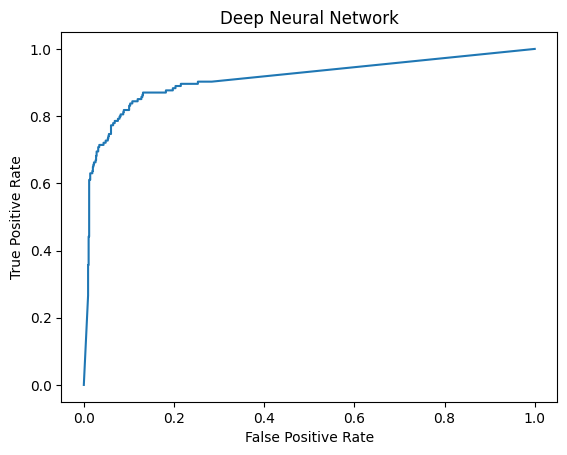

In [26]:
# SD: task 5
clf = MLPClassifier(hidden_layer_sizes=(5,2), activation="relu", solver="sgd",
                   random_state=42, max_iter=1000)
clf.fit(Xtrain_scaled, y_train)
q_prob = clf.predict_proba(Xtest_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, q_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Deep Neural Network")
plt.show()

In [ ]:
# SD: task 6
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}

grid_search = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1) # SD: because of n_jobs=-1, I can't suppress the warnings :( (kind of weird that warnings.filterwarnings only works with single-threading)
grid_search.fit(Xtrain_scaled, y_train)

print("Classification Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

/home/deshmus/Documents/GitHub/astr_8070_s25/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/deshmus/Documents/GitHub/astr_8070_s25/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/deshmus/Documents/GitHub/astr_8070_s25/venv/lib/python3.10/site-packages/sklearn/neural_network/_m

Classification Score: 0.9355
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'adam'}


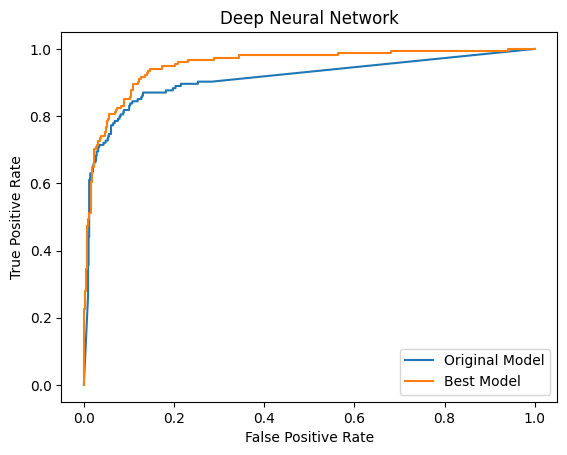

In [45]:
# SD: task 7
# SD: old model
clf = MLPClassifier(hidden_layer_sizes=(5,2), activation="relu", solver="sgd",
                   random_state=42, max_iter=1000)
clf.fit(Xtrain_scaled, y_train)
q_prob = clf.predict_proba(Xtest_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, q_prob)
plt.plot(fpr, tpr, label="Original Model")

# SD: best model
clf = MLPClassifier(**grid_search.best_params_)
clf.fit(Xtrain_scaled, y_train)
q_prob = clf.predict_proba(Xtest_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, q_prob)
plt.plot(fpr, tpr, label="Best Model")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Deep Neural Network")
plt.legend()
plt.show()

SRT: terrific work, Suyash.

50/50